## Image Segmentation Model

This notebook is an attempt to put into use what I've learned so far. The goal is the following: be able to prepare a dataset made of images, train a deep learning model with it and be able to use this model on new data to produce unsupervised results.
The model has to segment a given image and label each segment. Those images are aerial/satellite pictures and we want to automatically extract areas with recognizable structures like buildings, roads or vegetation on the pictures. This is a supervised categorization problem.

![satellite picture](./dataset/Tile%201/images/image_part_001.jpg) ![mask output](./dataset/Tile%201/masks/image_part_001.png)

### The dataset

In order to accomplish that, I need a dataset made of Earth pictures and a labeled mask for each of these pictures.
The "Semantic segmentation of aerial imagery" is an open dataset made of satellite images of Dubai and their mask couterpart that I will attempt to use for this project.

### The model

After looking for a model that take images as its input and its output in order to represent information over said images, the encoder-decoder architecture seems to be a good choice. Especially the U-Net model is made for this exact kind of applications. I will try to use this model for this project.

## Data Preprocessing

First, imports:

In [2]:
from pathlib import Path
import os
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

First, we get the images and masks paths:

In [3]:
data_path = Path(".") / "dataset"

tiles = ["Tile " + str(i) for i in range(1, 9)]

images_root_paths = [Path(data_path) / tile / "images" for tile in tiles]
masks_root_paths = [Path(data_path) / tile / "masks" for tile in tiles]

image_extension = '.jpg'
mask_extension = '.png'

In [4]:
images_paths = []
for path in images_root_paths:
	images_paths += [Path(path) / image for image in os.listdir(path) if os.path.isfile(Path(path) / image) and image.endswith(image_extension)]

images_paths.sort()
    
masks_paths = []
for path in masks_root_paths:
	masks_paths += [Path(path) / mask for mask in os.listdir(path) if os.path.isfile(Path(path) / mask) and mask.endswith(mask_extension)]

masks_paths.sort()
    
assert len(images_paths) == len(masks_paths) , "Not the same amount of images and masks paths."

print(f"{len(images_paths)} elements in dataset.")

72 elements in dataset.


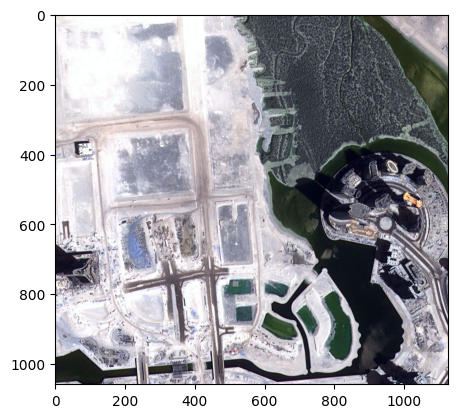

In [5]:
# Quick check to see if it's ok.
with Image.open(images_paths[42]) as img:
	plt.imshow(img)

I now have all the paths for the images and masks from the dataset.
Let's now prepare those. The first step is to split the shape of our images to standardize the input our model will take. We'll use the patchify library.
After documenting, I shall choose a patch size which is a 32 multiple. 128, 256 and 512 appear to be the most common choices.

In [6]:
patch_size = 256

(4, 4, 1, 256, 256, 3)


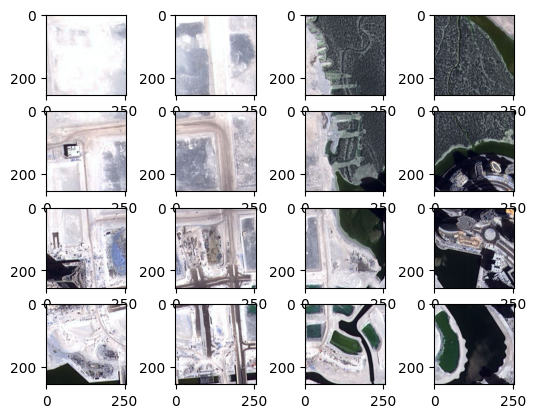

In [8]:
from patchify import patchify

with Image.open(images_paths[42]) as img:
    img = np.array(img)
    patches = patchify(img, patch_size=(patch_size, patch_size, 3), step=patch_size)

    print(patches.shape)

    f, ax = plt.subplots(len(patches), len(patches[0]))
    i = 0
    for patch_x in patches:
        j = 0
        for patch_y in patch_x:
            ax[i, j].imshow(patch_y[0])
            j += 1
        i += 1

Let's patchify all our data:

In [11]:
patched_images = []
for path in images_paths:
    image = Image.open(path)

    if (image.mode != 'RGB'):
        image = image.convert('RGB')

    image_arr = np.array(image)

    # Drop the image if it cannot be patched
    if (image_arr.shape[0] < patch_size or image_arr.shape[1] < patch_size):
        continue

    patches = patchify(image_arr, patch_size=(patch_size, patch_size, 3), step=patch_size)

    for patch_x in patches:
        for patch_y in patch_x:
            for patch in patch_y:
                patched_images.append(patch)

patched_masks = []
for path in masks_paths:
    mask = Image.open(path)

    if (mask.mode != 'RGB'):
        mask = mask.convert('RGB')

    mask_arr = np.array(mask)

    # Drop the mask if it cannot be patched
    if (mask_arr.shape[0] < patch_size or mask_arr.shape[1] < patch_size):
        continue

    patches = patchify(mask_arr, patch_size=(patch_size, patch_size, 3), step=patch_size)

    for patch_x in patches:
        for patch_y in patch_x:
            for patch in patch_y:
                patched_masks.append(patch)


assert len(patched_images) == len(patched_masks), "Not the same amount of patches for images and masks."
print(f"Total number of elements: {len(patched_images)}")

Total number of elements: 1305


We now have our data with the correct shape! We need to normalize it now.

In [12]:
normalized_images = [(image / 255.0) for image in patched_images]

#fig, ax_arr = plt.subplots(1, 2)
#ax_arr[0].imshow(patched_images[0])
#ax_arr[0].set_title("Before Normalizing")
#ax_arr[1].imshow(normalized_images[0])
#ax_arr[1].set_title("After Normalizing")
#plt.show()
#print("Just checking if the image remains the same before/after.")

assert len(normalized_images) == len(patched_masks), "Not the same amount of data before than after normalization."
assert np.array(normalized_images).shape == np.array(patched_masks).shape, "Normalized images and patched masks not of the same shape."

print(f"Number of normalized images = {len(normalized_images)}")

Number of normalized images = 1305


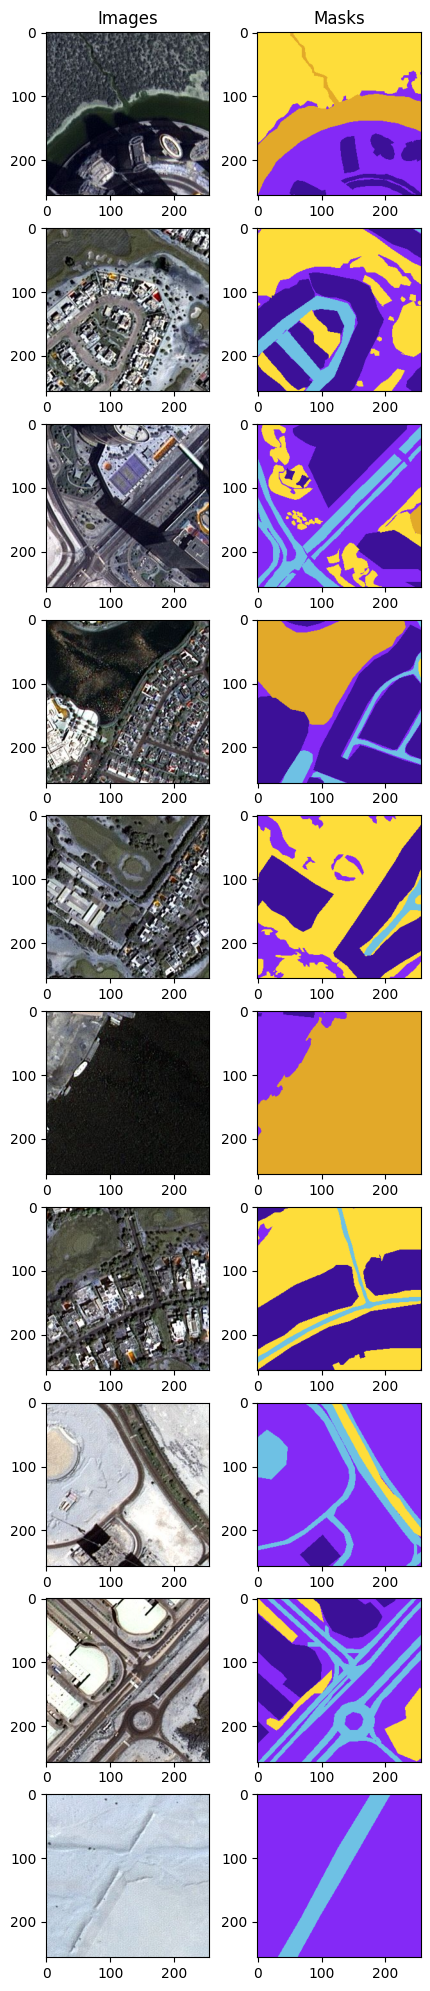

In [13]:
import random

fig, ax_arr = plt.subplots(10, 2, figsize=(5, 25))
ax_arr[0, 0].set_title("Images")
ax_arr[0, 1].set_title("Masks")

for i in range (0, 10):
	index = random.randint(0, len(normalized_images) - 1)
	ax_arr[i, 0].imshow(normalized_images[index])
	ax_arr[i, 1].imshow(patched_masks[index])

Our raw data is now be pretty much ready. Masks should not be normalized as they represent categorical value on an image.
Now we will process the categorical values for the segments.
We first create a dictionary containing all our labels' index and colors in RGB format. It will help encode our labels as well as probably decode future prediction made by the model.

In [14]:
# Manually getting those from the 'classes.json' file because there's no formatting convention on it:

classes = dict() # {key: (index, hex_color)

classes['Water'] = dict({'index': 0, 'color': 'E2A929'})
classes['Land'] = dict({'index': 1, 'color': '8429F6'})
classes['Road'] = dict({'index': 2, 'color': '6EC1E4'})
classes['Building'] = dict({'index': 3, 'color': '3C1098'})
classes['Vegetation'] = dict({'index': 4, 'color': 'FEDD3A'})
classes['Unlabeled'] = dict({'index': 5, 'color': '9B9B9B'})

# Convert hex to RGB:
for key in classes:
    color = classes[key]['color']
    color = tuple(int(color[i:i+2], 16) for i in (0, 2, 4))
    classes[key]['color'] = color

print(classes)

{'Water': {'index': 0, 'color': (226, 169, 41)}, 'Land': {'index': 1, 'color': (132, 41, 246)}, 'Road': {'index': 2, 'color': (110, 193, 228)}, 'Building': {'index': 3, 'color': (60, 16, 152)}, 'Vegetation': {'index': 4, 'color': (254, 221, 58)}, 'Unlabeled': {'index': 5, 'color': (155, 155, 155)}}


Then we create a function to convert each mask to a one-hot encoded label:

In [15]:
def rgb_to_class(mask: np.array) -> np.array:
    label_shape = (mask.shape[0], mask.shape[1], len(classes))
    label = np.zeros(shape=label_shape, dtype=np.float32)

    for key in classes:
        color = classes[key]['color']
        index = classes[key]['index']

        label[np.all(mask == color, axis=-1), index] = 1.0

    if (np.sum(label) != patch_size ** 2):	# Unknown color class
        unlabeled_index = classes['Unlabeled']['index']
        for col in label:
            for item in col:
                if np.sum(item) == 0:
                    item[unlabeled_index] = 1

    assert np.sum(label) == patch_size ** 2, "Unknown color class."

    return label

We create the whole label dataset:

In [16]:
labels = [rgb_to_class(mask) for mask in patched_masks]

assert len(labels) == len(patched_masks), "Error encoding masks to labels."

print(f"Number of labels = {len(labels)}")

Number of labels = 1305


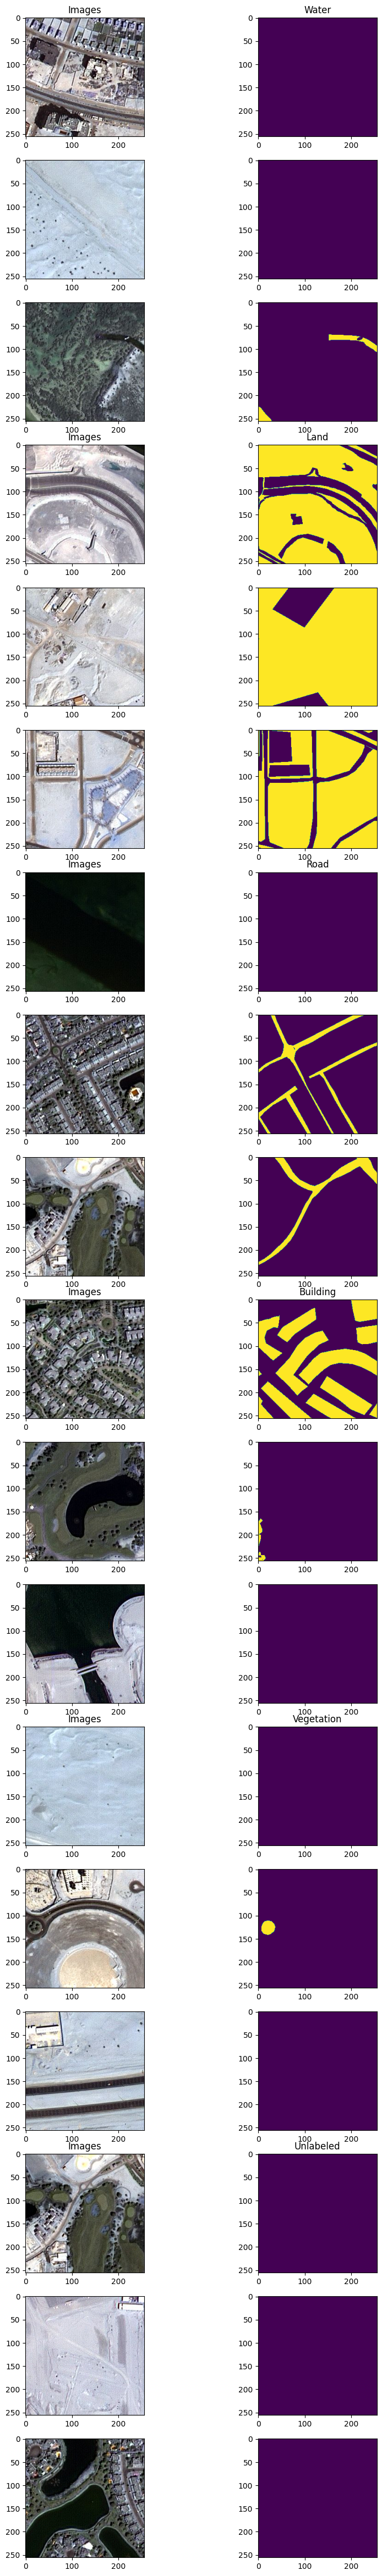

In [17]:
fig, ax_arr = plt.subplots(3 * len(classes), 2, figsize=(10, 60))

i = 0
for key in classes:
    ax_arr[i, 0].set_title("Images")
    ax_arr[i, 1].set_title(key)
    for j in range(0, 3):
        index = random.randint(0, len(normalized_images) - 1)
        ax_arr[i, 0].imshow(normalized_images[index])
        ax_arr[i, 1].imshow(labels[index][:, :, classes[key]['index']])
        i += 1

Now that we have both our preprocessed input images and our labelled output masks, we split the datasets into training and validation sets.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.asarray(normalized_images), np.asarray(labels), test_size=0.2, random_state=42)

We may augment the training dataset by flipping vertically some of the images/label mask pair:

(1353, 256, 256, 3)
(1353, 256, 256, 6)
(261, 256, 256, 3)
(261, 256, 256, 6)


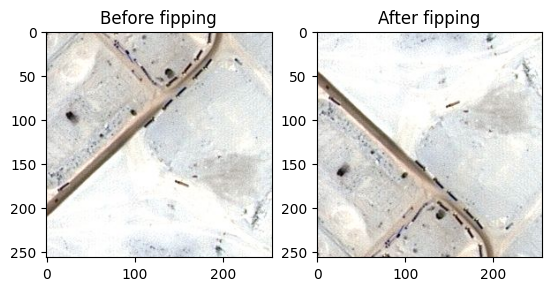

In [20]:
X_train_augmented = []
y_train_augmented = []

augmentation_rate = 0.3

for i in range(0, len(X_train)):
    if (random.random() < augmentation_rate):
        X_train_augmented += [np.flipud(X_train[i])]
        y_train_augmented += [np.flipud(y_train[i])]

X_train_augmented = np.append(X_train, X_train_augmented, axis=0)
y_train_augmented = np.append(y_train, y_train_augmented, axis=0)

assert len(X_train_augmented) == len(y_train_augmented) and len(X_test) == len(y_test), "Discrepency in the amount of data in training datasets or testing datasets."

fig, ax_arr = plt.subplots(1, 2)
ax_arr[0].imshow(X_train[42])
ax_arr[0].set_title("Before fipping")
ax_arr[1].imshow(np.flipud(X_train[42]))
ax_arr[1].set_title("After fipping")

print(X_train_augmented.shape)
print(y_train_augmented.shape)
print(X_test.shape)
print(y_test.shape)

We can now check that training and testing sets have the right dimensions!
Data preprocessing is done, we must now implement a model.

## Model creation, training and evaluation
For training purposes I will use keras.
I will be implementing the following U-Net architecture, as described in this [publication](https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/).
![U-Net architecture](assets/u-net-architecture.png)

In [27]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization
from keras import backend

They evaluate the performance using an IoU matrix (Intersect over Union), I will use the same metric to evaluate my own.

In [28]:
def iou_evaluate(y_true, y_pred):
    y_true_flat = backend.flatten(y_true)
    y_pred_flat = backend.flatten(y_pred)

    inter = backend.sum(y_true_flat * y_pred_flat)
    union = backend.sum(y_true_flat) + backend.sum(y_pred_flat) - inter

    return (inter + 1.0) / (union + 1.0)

Now defining the model:

In [29]:
def unet_model(num_classes, image_height, image_width, image_channels):

    inputs = Input(shape=(image_height, image_width, image_channels))

    # May test Conv2D with kernel_initializer="he_normal"

    # 2 convolution with 3x3 kernel and relu activation + batch normalization
    conv1 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(conv1)

    # 2x2 Pooling
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(conv2)

    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(conv3)

    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(conv4)

    pool4 = MaxPooling2D((2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(conv5)

    # 2x2 Up convolution
    upconv6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), kernel_initializer="he_normal", padding="same")(conv5)

    # Skipping layer: concatenate
    upconv6 = concatenate([upconv6, conv4])

    # 2 convolution with 3x3 kernel and relu activation + dropout layer
    upconv6 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(upconv6)
    upconv6 = BatchNormalization()(upconv6)
    upconv6 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(upconv6)

    upconv7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), kernel_initializer="he_normal", padding="same")(upconv6)

    upconv7 = concatenate([upconv7, conv3])

    upconv7 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(upconv7)
    upconv7 = BatchNormalization()(upconv7)
    upconv7 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(upconv7)

    upconv8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), kernel_initializer="he_normal", padding="same")(upconv7)

    upconv8 = concatenate([upconv8, conv2])

    upconv8 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(upconv8)
    upconv8 = BatchNormalization()(upconv8)
    upconv8 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(upconv8)

    upconv9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), kernel_initializer="he_normal", padding="same")(upconv8)

    upconv9 = concatenate([upconv9, conv1])

    upconv9 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(upconv9)
    upconv9 = BatchNormalization()(upconv9)
    upconv9 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(upconv9)

    # Final softmax activation for classification
    output = Conv2D(num_classes, (1, 1), activation="softmax", kernel_initializer="he_normal",)(upconv9)

    unet_model = Model(inputs=[inputs], outputs=[output])
    return unet_model

I've added batch normalization layers between successive convolution layers in order to improve convergence speed, as stated in this [article](https://arxiv.org/abs/1809.03783).

In [30]:
num_classes = len(classes)
unet = unet_model(num_classes=num_classes, image_height=patch_size, image_width=patch_size, image_channels=3)

Lastly, we need a loss function before training the model. In the paper, they use cross entropy so I will use keras' categorical cross entropy loss function.

Let's now compile our model:

In [33]:
keras.backend.clear_session()
# We use adam optimizer as described here https://arxiv.org/pdf/2007.02839.pdf
optimizer = keras.optimizers.Adam()
unet.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", iou_evaluate])

Now we train our model:

In [34]:
num_epochs = 200
training_history = unet.fit(X_train_augmented, y_train_augmented, batch_size=32, verbose=1, epochs=num_epochs, validation_data=(X_test, y_test))

Epoch 1/200
43/43 [==============================] - 25s 340ms/step - loss: 0.7264 - accuracy: 0.7520 - iou_evaluate: 0.4890 - val_loss: 2.0595 - val_accuracy: 0.1918 - val_iou_evaluate: 0.1446
Epoch 2/200
43/43 [==============================] - 13s 306ms/step - loss: 0.6499 - accuracy: 0.7810 - iou_evaluate: 0.5227 - val_loss: 1.6670 - val_accuracy: 0.5158 - val_iou_evaluate: 0.2701
Epoch 3/200
43/43 [==============================] - 13s 308ms/step - loss: 0.6070 - accuracy: 0.7978 - iou_evaluate: 0.5478 - val_loss: 1.8533 - val_accuracy: 0.5366 - val_iou_evaluate: 0.3372
Epoch 4/200
43/43 [==============================] - 14s 315ms/step - loss: 0.5768 - accuracy: 0.8076 - iou_evaluate: 0.5618 - val_loss: 1.9759 - val_accuracy: 0.5642 - val_iou_evaluate: 0.3633
Epoch 5/200
43/43 [==============================] - 14s 318ms/step - loss: 0.5500 - accuracy: 0.8159 - iou_evaluate: 0.5778 - val_loss: 1.7817 - val_accuracy: 0.5459 - val_iou_evaluate: 0.3496
Epoch 6/200
43/43 [===========

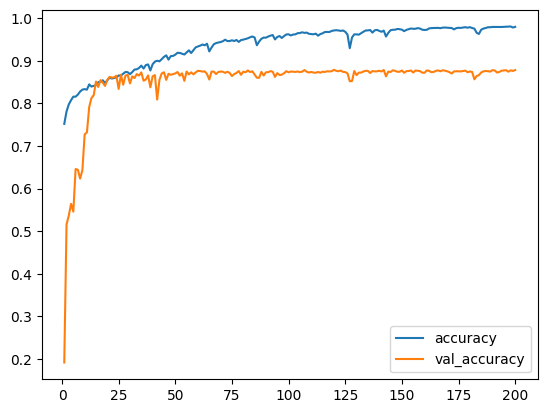

In [35]:
history_copy = training_history.history

f, ax = plt.subplots()
ax.plot([i for i in range(1, num_epochs + 1)], history_copy['accuracy'], label='accuracy')
ax.plot([i for i in range(1, num_epochs + 1)], history_copy['val_accuracy'], label='val_accuracy')
ax.legend()
plt.show()

We reach a maximum validation accuracy of around 88%, stabilizing after ~50 epochs. Let's now try to predict using our model, and visualize the output:

In [36]:
y_pred = unet.predict(X_test)

9/9 [==============================] - 1s 83ms/step


We categorize the ouput's channels using argmax().

In [37]:
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

Definition of the decoding function to rebuild the RGB mask from the one-hot encoded label:

In [38]:
convert_table = [None] * len(classes)
for key in classes:
    convert_table[classes[key]['index']] = classes[key]['color']

print(convert_table)

def cat_to_rgb(label: np.array) -> np.array:

    mask_shape = (label.shape[0], label.shape[1], 3)
    mask = np.zeros(shape=mask_shape, dtype=np.uint8)

    for i in range(mask_shape[0]):
        for j in range(mask_shape[1]):
            index = label[i, j]
            mask[i, j] = convert_table[index]

    return mask

[(226, 169, 41), (132, 41, 246), (110, 193, 228), (60, 16, 152), (254, 221, 58), (155, 155, 155)]


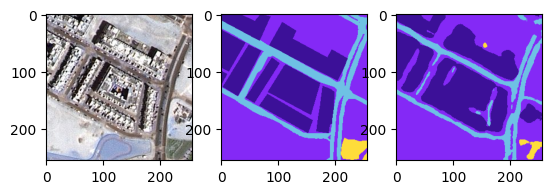

In [46]:
index = 200

img = X_test[index]

true_mask = cat_to_rgb(y_test_argmax[index])
pred_mask = cat_to_rgb(y_pred_argmax[index])

fig, ax_arr = plt.subplots(1, 3)
ax_arr[0].imshow(img)
ax_arr[1].imshow(true_mask)
ax_arr[2].imshow(pred_mask)

In [40]:
unet.save("aerial_images_segmentation_v7.h5")

Satellite images have a precision of about 1m/pixel in our case. In order to get good future prediction, we should input images with about the same precision.

## Discussion

We have a proof of concept that the unet architecture can be adapted to satellite imagery, even using a small training dataset and limited training time. However there are multiple improvements that can be made.

The first one is data: we only used a small dataset of 72 images, and it is quite imbalanced as those are only from Dubai. It may be difficult to get a goood prediction from places with a completely different climate, vegetation, urban organisation or weather.

There is also the data augmentation process: I kept it very simple and limited, but there are many augmentations that could be made as well as semi-supervised learning.

Then, regarding the model, a lot of experimentation could be done on the hyperparameters, initialization arguments and architecture. Changing the learning rate, batch_size, kernel initializer, batch normalization placement, etc... can modify the behavior of the model.

Finally a lot of completely different approches could be explored: different model, fine-tuning a pre-trained model or transfer learning for example. We could also look into layer activations map in order to qualitatively analyse what features are analysed by the network.